## Weather forecast Kalman Fitler

In [1]:
import pandas as pd

In [2]:
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

In [3]:
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [4]:
import filterpy.stats as stats
import kf_book.kf_internal as kf_internal
from collections import namedtuple

In /Users/flaviaferrusmarimon/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/flaviaferrusmarimon/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/flaviaferrusmarimon/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/flaviaferrusmarimon/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [5]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [7]:
import numpy as np
# create list of measurements
zs = df['T (degC)']
print(np.mean(zs))
zs

9.450147354304178


0        -8.02
1        -8.41
2        -8.51
3        -8.31
4        -8.27
          ... 
420546   -4.05
420547   -3.35
420548   -3.16
420549   -4.23
420550   -4.82
Name: T (degC), Length: 420551, dtype: float64

In [8]:
T = 52560
zt = zs[:T]
zt

0       -8.02
1       -8.41
2       -8.51
3       -8.31
4       -8.27
         ... 
52555   -2.74
52556   -2.82
52557   -2.84
52558   -2.84
52559   -2.85
Name: T (degC), Length: 52560, dtype: float64

But let us have a more smoothed and less dimensional time series: 

In [9]:
ztt = []
for i in range(int(len(zt)/10)): 
    ztt.append(zt[i*10])
    
ztt = np.array(ztt)
print(len(ztt))
ztt

5256


array([-8.02, -8.76, -8.94, ..., -1.1 , -1.54, -2.5 ])

In [10]:
process_var = 1. # variance in the temperature
sensor_var = 2. # variance in the sensor

x = gaussian(np.mean(ztt), 20.**2)  # Initial temperature N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x

$PV = nRT$ we can construct a relationship among the variables of $P$ and $T$, since they both appear to be related by a linear regression (when assuming ideal gases law). 

In [11]:
x

𝒩(μ=8.832, 𝜎²=400.000)

In [12]:
process_model

𝒩(μ=1.000, 𝜎²=1.000)

In [13]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

In [14]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior


In [15]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zt:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  9.832  401.000	-8.020	 -7.931   1.990
 -6.931    2.990	-8.410	 -7.817   1.198
 -6.817    2.198	-8.510	 -7.704   1.047
 -6.704    2.047	-8.310	 -7.516   1.012
 -6.516    2.012	-8.270	 -7.396   1.003
 -6.396    2.003	-8.050	 -7.223   1.001
 -6.223    2.001	-7.620	 -6.922   1.000
 -5.922    2.000	-7.620	 -6.771   1.000
 -5.771    2.000	-7.910	 -6.840   1.000
 -5.840    2.000	-8.430	 -7.135   1.000
 -6.135    2.000	-8.760	 -7.448   1.000
 -6.448    2.000	-8.880	 -7.664   1.000
 -6.664    2.000	-8.850	 -7.757   1.000
 -6.757    2.000	-8.830	 -7.793   1.000
 -6.793    2.000	-8.660	 -7.727   1.000
 -6.727    2.000	-8.660	 -7.693   1.000
 -6.693    2.000	-8.700	 -7.697   1.000
 -6.697    2.000	-8.810	 -7.753   1.000
 -6.753    2.000	-8.840	 -7.797   1.000
 -6.797    2.000	-8.940	 -7.868   1.000
 -6.868    2.000	-8.940	 -7.904   1.000
 -6.904    2.000	-8.860	 -7.882   1.000
 -6.882    2.000	-8.990	 -7.936   1.000
 -6.936    2.000	-9.050	 -7

NameError: name 'dog' is not defined

In [18]:
ztt[-1]

-2.5

In [22]:
len(zt)

52560

In [24]:
zs[T + 10]

-3.1

In [32]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider
from ipywidgets import interact
import matplotlib.pyplot as plt

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(np.mean(ztt), 20.**2)
for z in ztt:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, T/10)
    plt.ylim(-30, 40)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=15768, min=1), Output()), _dom_classes=('widg…

In [36]:
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(T/10 - 20, T/10)
    plt.ylim(-10, 10)
    plt.legend(loc=1);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=15768, min=1), Output()), _dom_classes=('widg…

In [38]:
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(T/10 - 20 - 1000, T/10- 1000)
    plt.ylim(-10, 10)
    plt.legend(loc=3);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=15768, min=1), Output()), _dom_classes=('widg…

In [42]:
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(T/10 - 20 - 2000, T/10- 2000)
    plt.ylim(10, 30)
    plt.legend(loc=1);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=15768, min=1), Output()), _dom_classes=('widg…

In [46]:
def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(ztt[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(T/10 - 20 - 3000, T/10- 3000)
    plt.ylim(0, 16)
    plt.legend(loc=3);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=15768, min=1), Output()), _dom_classes=('widg…

In [47]:
print(len(ztt))
print(len(xs))

5256
5256


In [48]:
print(np.linalg.norm(ztt - xs))

110.13736575775889


In [49]:
print((ztt[-1] - xs[-1])**2)

2.46644004734975


In [50]:
print(ztt[-1])
print(xs[-1])

-2.5
-0.9295096156455622


In [52]:
print(np.mean(xs))

9.830811666116027


In [53]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider
from ipywidgets import interact
import matplotlib.pyplot as plt

ztt2 = []
for i in range(int(len(ztt)/10)): 
    ztt2.append(ztt[i*10])
    
ztt2 = np.array(ztt2)
print(len(ztt2))
#ztt

# save output in these lists for plotting
xs2, predictions2 = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(np.mean(ztt2), 20.**2)
for z in ztt2:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions2.append(prior.mean)
    xs2.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions2[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt2[:i-1])
        book_plots.plot_filter(xs2[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt2[:i])
        book_plots.plot_filter(xs2[:i-1])
    else:
        book_plots.plot_measurements(ztt2[:i])
        book_plots.plot_filter(xs2[:i])
    
    plt.xlim(-1, T/100)
    plt.ylim(-30, 40)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions2)*3));

525


interactive(children=(IntSlider(value=1, description='step', max=1575, min=1), Output()), _dom_classes=('widge…

In [54]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider
from ipywidgets import interact
import matplotlib.pyplot as plt

ztt3 = []
for i in range(int(len(ztt2)/10)): 
    ztt3.append(ztt2[i*10])
    
ztt3 = np.array(ztt3)
print(len(ztt3))
#ztt

# save output in these lists for plotting
xs3, predictions3 = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(np.mean(ztt3), 20.**2)
for z in ztt3:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions3.append(prior.mean)
    xs3.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions3[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(ztt3[:i-1])
        book_plots.plot_filter(xs3[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(ztt3[:i])
        book_plots.plot_filter(xs3[:i-1])
    else:
        book_plots.plot_measurements(ztt3[:i])
        book_plots.plot_filter(xs3[:i])
    
    plt.xlim(-1, T/1000)
    plt.ylim(-30, 40)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions3)*3));

52


interactive(children=(IntSlider(value=1, description='step', max=156, min=1), Output()), _dom_classes=('widget…

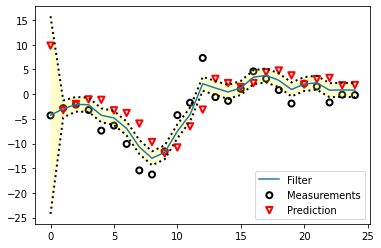

	1.9901 1.1984 1.0473 1.0117 1.0029
	1.0007 1.0002 1.0000 1.0000 1.0000
	1.0000 1.0000 1.0000 1.0000 1.0000
	1.0000 1.0000 1.0000 1.0000 1.0000
	1.0000 1.0000 1.0000 1.0000 1.0000


In [58]:
#process_var = 2.
#sensor_var = 4.5
x = gaussian(np.mean(ztt2), 400.)
process_model = gaussian(1., process_var)
N = 25

#dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
#zs = [dog.move_and_sense() for _ in range(N)]
ztt_s = ztt2[-N:]
xss, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(ztt_s):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xss[i] = x

book_plots.plot_measurements(ztt_s)
book_plots.plot_filter(xss[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
#book_plots.show_legend()
plt.legend(loc=4);
plt.show()
kf_internal.print_variance(xss)

In [60]:
xss[2]

array([-2.05724742,  1.04725808])

In [61]:
ztt_s[2]

-2.12

In [63]:
print((xss[2,0] - ztt_s[2])**2)

0.003937886373288982
